In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-change-edsa2020-21/sample_submission.csv
/kaggle/input/climate-change-edsa2020-21/test.csv
/kaggle/input/climate-change-edsa2020-21/train.csv


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **Load and clean data**

In [3]:
df = pd.read_csv('/kaggle/input/climate-change-edsa2020-21/train.csv')
df_test = pd.read_csv('/kaggle/input/climate-change-edsa2020-21/test.csv')

In [4]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
len(df) #number of tweets

15819

In [6]:
df.sentiment.value_counts() #distribution of pro to anti sentiments *BALANCE

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [7]:
from sklearn.utils import resample

In [8]:
positive1 = df[df['sentiment']==1]
news2 = df[df['sentiment']==2]
neutral0 = df[df['sentiment']==0]
negative1 = df[df['sentiment']==-1]


In [9]:
# Downsample majority
positive1_downsampled = resample(positive1,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(negative1), # match number in minority class
                          random_state=27) # reproducible results
news2_downsampled = resample(news2,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(negative1), # match number in minority class
                          random_state=27) # reproducible results
neutral0_downsampled = resample(neutral0,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(negative1), # match number in minority class
                          random_state=27) # reproducible results


# Combine downsampled majority class with minority class
df_d = pd.concat([positive1_downsampled,news2_downsampled, neutral0_downsampled, negative1])



In [10]:
df_d.sentiment.value_counts() #distribution of sentiments

-1    1296
 2    1296
 1    1296
 0    1296
Name: sentiment, dtype: int64

In [11]:
df_d.head()

,sentiment,message,tweetid
11729,1,RT @ubcforestry: Funding from @GenomeBC will s...,977844
8308,1,@YadiMoIina gag orders? Sure. He's definitely ...,441956
7159,1,RT @pattonoswalt: Not ominous at all! (He also...,978938
5644,1,RT @MelissaJPeltier: In case you forgot about ...,587737
6732,1,RT @SethMacFarlane: HRC proposes installing ha...,804767


In [12]:
len(df_d) 

5184

In [13]:
#remove empty strings
#blanks_test = []

#for i,msg, twid in df_test.itertuples():
    #if msg.isspace():
        #blanks_test.append(i) #returns index positions for where there is empty string in message col


In [14]:
#blanks_test

In [15]:
#df_test.drop(blanks_test, inplace = True)

Modelling

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = df_d['message']
y = df_d['sentiment']

In [18]:
X.shape

(5184,)

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y,test_size=0.3, shuffle=True, stratify=y, random_state =17)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [22]:
text_clf = Pipeline([('clf', LinearSVC())])

In [23]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('clf', LinearSVC())])

In [24]:
predictions = text_clf.predict(X_val)

In [25]:
predictions

array([ 2,  2,  0, ..., -1,  0,  1])

# Checking the performance of our model on the validation set****

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [27]:
print(confusion_matrix(y_val, predictions))

[[276  65  28  20]
 [ 63 213  78  35]
 [ 42  74 201  72]
 [  8  20  57 304]]


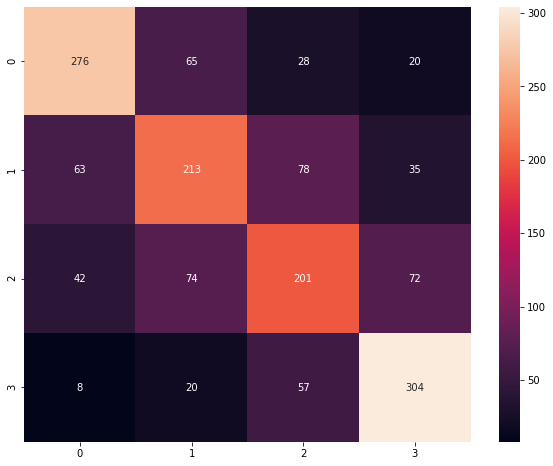

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
cf_matrix = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [29]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

          -1       0.71      0.71      0.71       389
           0       0.57      0.55      0.56       389
           1       0.55      0.52      0.53       389
           2       0.71      0.78      0.74       389

    accuracy                           0.64      1556
   macro avg       0.63      0.64      0.64      1556
weighted avg       0.63      0.64      0.64      1556



In [30]:
f1_score(y_val, predictions, average="macro")

0.636157318729681

In [31]:
print(accuracy_score(y_val, predictions))

0.6388174807197944


**Getting our test set ready**

In [32]:
test_x = df_test['message']
test_vect = vectorizer.transform(test_x)

**Making predictions on the test set and adding a sentiment column to our original test df**

In [33]:
y_pred = text_clf.predict(test_vect)

In [34]:
df_test['sentiment'] = y_pred

In [35]:
df_test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,2
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,0
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,0
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


In [36]:
df_test['message'].iloc[2]

'The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..'

**Creating an output csv for submission**

In [37]:
df_test[['tweetid','sentiment']].to_csv('testsubmission_SVC_2.csv', index=False)